In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

2024-04-12 01:15:20.289716: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 01:15:20.289813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 01:15:20.426199: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_SHAPE = (256, 256, 1)
BATCH_SIZE = 16
noise_dim = 128

In [3]:
train_images = np.load('/kaggle/input/lofi-songs/normed_songs.npy')

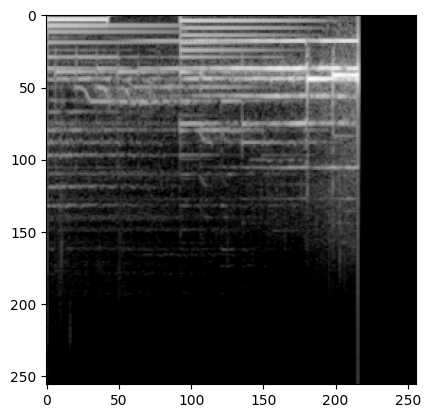

In [4]:
plt.imshow(train_images[345], cmap='gray')
plt.show()

In [5]:
train_images = (train_images - 127.5) / 127.5

In [6]:
def conv_block(x, filters, activation, kernel_size=(3, 3), strides=(1, 1), padding="same", 
               use_bias=True, use_bn=False, use_dropout=False, drop_value=0.5):
    
    x = layers.Conv2D(filters, kernel_size, strides=strides, 
                      padding=padding, use_bias=use_bias)(x)
    
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
        
    return x

In [7]:
def upsample_block(x, filters, activation, kernel_size=(3, 3), strides=(1, 1), up_size=(2, 2), padding="same",
                   use_bn=False, use_bias=True, use_dropout=False, drop_value=0.3):
    
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(filters, kernel_size, strides=strides, 
                      padding=padding, use_bias=use_bias)(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
        
    return x

In [8]:
def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(8 * 8 * 1024, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((8, 8, 1024))(x)
    
    x = upsample_block(x, 512, layers.LeakyReLU(0.2), strides=(1, 1), use_bias=False, 
                       use_bn=True, padding="same", use_dropout=False)
    
    x = upsample_block(x, 256, layers.LeakyReLU(0.2), strides=(1, 1), use_bias=False, 
                       use_bn=True, padding="same", use_dropout=False)
    
    x = upsample_block(x, 128, layers.LeakyReLU(0.2), strides=(1, 1), use_bias=False, 
                       use_bn=True, padding="same", use_dropout=False)
    
    x = upsample_block(x, 64, layers.LeakyReLU(0.2), strides=(1, 1), use_bias=False, 
                       use_bn=True, padding="same", use_dropout=False)
    
    x = upsample_block(x, 1, layers.Activation("tanh"), strides=(1, 1), 
                       use_bias=False, use_bn=True)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 65536)          │     8,388,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 65536)          │       262,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 1024)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 512)    │     4,718,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 256)    │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,922,052 (56.92 MB)

 Trainable params: 14,789,058 (56.42 MB)

 Non-trainable params: 132,994 (519.51 KB)

In [9]:
def get_discriminator_model():
    
    img_input = layers.Input(shape=IMG_SHAPE)

    x = conv_block(img_input, 64, kernel_size=(5, 5), strides=(2, 2), use_bn=False, use_bias=True, 
                   activation=layers.LeakyReLU(0.2), use_dropout=False, drop_value=0.3)

    x = conv_block(x, 128, kernel_size=(5, 5), strides=(2, 2), use_bn=False, use_bias=True, 
                   activation=layers.LeakyReLU(0.2), use_dropout=True, drop_value=0.3)
    
    x = conv_block(x, 256, kernel_size=(5, 5), strides=(2, 2), use_bn=False, use_bias=True, 
                   activation=layers.LeakyReLU(0.2), use_dropout=True, drop_value=0.3)
    
    x = conv_block(x, 512, kernel_size=(5, 5), strides=(2, 2), use_bn=False, use_bias=True, 
                   activation=layers.LeakyReLU(0.2), use_dropout=False, drop_value=0.3)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 512)    │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,434,433 (16.92 MB)

 Trainable params: 4,434,433 (16.92 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: explainable-ai-sdk, tensorflow-cloud, tensorflow-decision-forests, tensorflow-serving-api, tensorflow-text, tf_keras, witwidget


In [10]:
class WGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, 
                 discriminator_extra_steps=3, gp_weight=10.0):
        super(WGAN, self).__init__()
        
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
    def gradient_penalty(self, batch_size, real_images, fake_images):
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        # Train the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [11]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))

In [12]:
generator_optimizer = keras.optimizers.Adam(
	learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

In [13]:
epochs = 30

# Instantiate the custom defined Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Instantiate the WGAN model.
wgan = WGAN(discriminator=d_model,
			generator=g_model,
            latent_dim=noise_dim,
            discriminator_extra_steps=3,)

# Compile the WGAN model.
wgan.compile(d_optimizer=discriminator_optimizer,
			 g_optimizer=generator_optimizer,
             g_loss_fn=generator_loss,
             d_loss_fn=discriminator_loss,)

# Start training the model.
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

Epoch 1/30


I0000 00:00:1712884625.208289      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


295/295 ━━━━━━━━━━━━━━━━━━━━ 324s 806ms/step - d_loss: -442.4387 - g_loss: 636.5291 - loss: 0.0000e+00
Epoch 2/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 182s 616ms/step - d_loss: -364.8488 - g_loss: 717.6563 - loss: 0.0000e+00
Epoch 3/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 182s 617ms/step - d_loss: -279.7658 - g_loss: 736.0641 - loss: 0.0000e+00
Epoch 4/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 182s 616ms/step - d_loss: -217.2278 - g_loss: 732.0870 - loss: 0.0000e+00
Epoch 5/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 182s 616ms/step - d_loss: -162.6176 - g_loss: 560.4529 - loss: 0.0000e+00
Epoch 6/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 182s 616ms/step - d_loss: -125.8435 - g_loss: 454.9496 - loss: 0.0000e+00
Epoch 7/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 182s 617ms/step - d_loss: -98.5038 - g_loss: 383.2861 - loss: 0.0000e+00
Epoch 8/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 182s 617ms/step - d_loss: -77.6898 - g_loss: 300.2021 - loss: 0.0000e+00
Epoch 9/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 182s 617ms/step - d_loss: -60.9530 - g_loss: 263.6358 - loss:

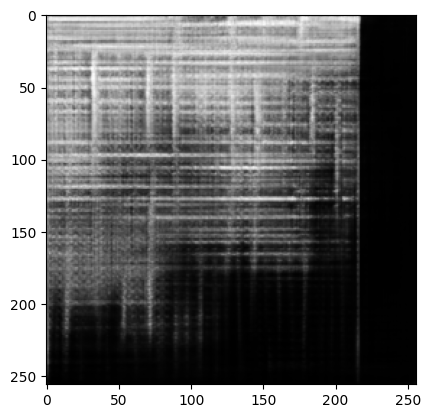

In [14]:
random_latent_vectors = tf.random.normal(shape=(1, noise_dim))
generated_images = wgan.generator(random_latent_vectors, training=False)
generated_images = (generated_images * 127.5) + 127.5
plt.imshow(generated_images[0], cmap='gray')
plt.show()

In [18]:
wgan.save_weights('wgan_songs.weights.h5')

In [19]:
!zip -r output.zip /kaggle/working/

updating: kaggle/working/ (stored 0%)
updating: kaggle/working/generated_img_1_18.png (deflated 0%)
updating: kaggle/working/generated_img_1_17.png (deflated 0%)
updating: kaggle/working/generated_img_2_8.png (deflated 0%)
updating: kaggle/working/generated_img_2_18.png (deflated 0%)
updating: kaggle/working/generated_img_2_22.png (deflated 0%)
updating: kaggle/working/generated_img_1_1.png (stored 0%)
updating: kaggle/working/generated_img_0_12.png (deflated 0%)
updating: kaggle/working/generated_img_0_23.png (deflated 0%)
updating: kaggle/working/generated_img_2_27.png (deflated 0%)
updating: kaggle/working/generated_img_2_19.png (deflated 0%)
updating: kaggle/working/generated_img_0_24.png (deflated 0%)
updating: kaggle/working/generated_img_1_13.png (deflated 0%)
updating: kaggle/working/generated_img_2_20.png (deflated 0%)
updating: kaggle/working/generated_img_2_24.png (deflated 0%)
updating: kaggle/working/generated_img_1_23.png (deflated 0%)
updating: kaggle/working/generated_i

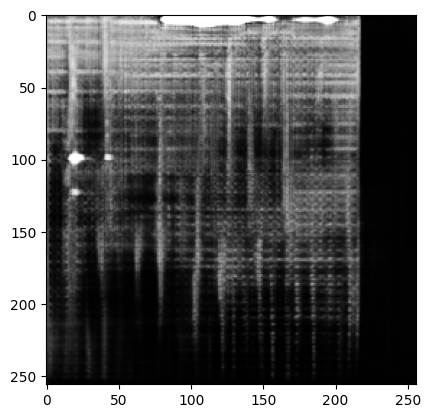

In [20]:
random_latent_vectors = tf.random.normal(shape=(1, noise_dim))
generated_images = wgan.generator(random_latent_vectors, training=False)
generated_images = (generated_images * 127.5) + 127.5
plt.imshow(generated_images[0], cmap='gray')
plt.show()

In [21]:
!mkdir photos

In [25]:
from PIL import Image
from tqdm import tqdm
for n in tqdm(range(100)):
    random_latent_vectors = tf.random.normal(shape=(1, noise_dim))
    generated_images = wgan.generator(random_latent_vectors, training=False)
    generated_images = np.array((generated_images[0] * 127.5) + 127.5, dtype=np.uint8).reshape(256, 256)
    img = Image.fromarray(generated_images)
    img.save(f"/kaggle/working/photos/photo_gened_{n}.png")

100%|██████████| 100/100 [00:04<00:00, 22.28it/s]


In [26]:
!zip -r photos.zip /kaggle/working/photos

  adding: kaggle/working/photos/ (stored 0%)
  adding: kaggle/working/photos/photo_gened_94.png (deflated 0%)
  adding: kaggle/working/photos/photo_gened_81.png (deflated 0%)
  adding: kaggle/working/photos/photo_gened_53.png (deflated 0%)
  adding: kaggle/working/photos/photo_gened_3.png (deflated 0%)
  adding: kaggle/working/photos/photo_gened_16.png (deflated 0%)
  adding: kaggle/working/photos/photo_gened_27.png (deflated 0%)
  adding: kaggle/working/photos/photo_gened_83.png (deflated 0%)
  adding: kaggle/working/photos/photo_gened_44.png (deflated 0%)
  adding: kaggle/working/photos/photo_gened_0.png (deflated 0%)
  adding: kaggle/working/photos/photo_gened_71.png (deflated 0%)
  adding: kaggle/working/photos/photo_gened_15.png (deflated 0%)
  adding: kaggle/working/photos/photo_gened_86.png (deflated 0%)
  adding: kaggle/working/photos/photo_gened_87.png (deflated 0%)
  adding: kaggle/working/photos/photo_gened_54.png (deflated 0%)
  adding: kaggle/working/photos/photo_gened_23.

In [34]:
wgan.save("new_file.h5", overwrite=True)

ValueError: Unable to synchronously create dataset (name already exists)

In [35]:
wgan.load_weights("/kaggle/working/wgan_songs.weights.h5")

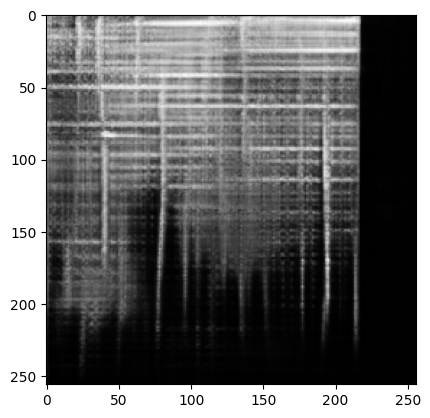

In [42]:
random_latent_vectors = tf.random.normal(shape=(1, noise_dim))
generated_images = wgan.generator(random_latent_vectors, training=False)
generated_images = (generated_images * 127.5) + 127.5
plt.imshow(generated_images[0], cmap='gray')
plt.show()